In [1]:
import os
import sys
import time

import numpy as np
import pylab as pyy
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Concatenate, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

2024-11-15 00:08:31.326672: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-15 00:08:32.739221: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-15 00:08:32.739268: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-15 00:08:32.745890: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-15 00:08:33.338549: I tensorflow/core/platform/cpu_feature_g

In [2]:
PATH = "/tmp/gan-detector"

if not os.path.exists(PATH):
    os.makedirs(PATH)

In [3]:
print("Versione di Python:", sys.version)
print("Versione di TensorFlow:", tf.__version__)
print("Versione di Keras:", keras.__version__)

Versione di Python: 3.10.14 | packaged by conda-forge | (main, Mar 20 2024, 12:45:18) [GCC 12.3.0]
Versione di TensorFlow: 2.14.1
Versione di Keras: 2.14.0


### Useful Functions

In [4]:
def tri_mom(P):
    # calcualtes the absolute value of the momentum
    
    return np.sqrt(P[:,1]*P[:,1] + P[:,2]*P[:,2] + P[:,3]*P[:,3])


def calculate_errors_and_pulls(real_data, generated_data, bins=50):
    # quantifies the error between real and generated data
    
    hist_real, edges_real = np.histogram(real_data, bins=bins)
    hist_generated, edges_generated = np.histogram(generated_data, bins=bins)
    bin_centers = 0.5 * (edges_real[1:] + edges_real[:-1])

    err_real = np.sqrt(hist_real)
    err_generated = np.sqrt(hist_generated)

    epsilon = 1e-7
    pulls = np.where((hist_real != 0) | (hist_generated != 0),
                     (hist_real - hist_generated) / np.sqrt(hist_real + hist_generated + epsilon),
                             0.0)

    return bin_centers, hist_real, hist_generated, err_real, err_generated, pulls

### Training Dataset building

In [5]:
four_mom = (0.1, 0.05, 0.07, -0.5)

identical_events = np.tile(four_mom, (100000, 1))

std_dev_smearing = np.array([0.1, 0.6, 0.4, 0.7])

# Generate smeared events by adding Gaussian noise to each event
smeared_events = identical_events + np.random.normal(loc=0, scale=std_dev_smearing, size=(100000, 4))


P_PS = tri_mom(identical_events)
P_smeared = tri_mom(smeared_events)

print(P_PS.shape, P_smeared.shape)

V_data_tensor = tf.convert_to_tensor(identical_events, dtype=tf.float32)
smeared_data_tensor = tf.convert_to_tensor(smeared_events, dtype=tf.float32)

print(V_data_tensor.shape, smeared_data_tensor.shape)

(100000,) (100000,)


2024-11-15 00:08:44.063948: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-15 00:08:44.167247: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-15 00:08:44.167545: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

(100000, 4) (100000, 4)


In [6]:
tf.io.write_file(f'{PATH}/V_data', tf.io.serialize_tensor(V_data_tensor))
tf.io.write_file(f'{PATH}/smeared_data', tf.io.serialize_tensor(smeared_data_tensor))

In [7]:
!ls -lrth /tmp/gan-detector

total 3.1M
-rw-r--r-- 1 root root 1.6M Nov 15 00:08 V_data
-rw-r--r-- 1 root root 1.6M Nov 15 00:08 smeared_data


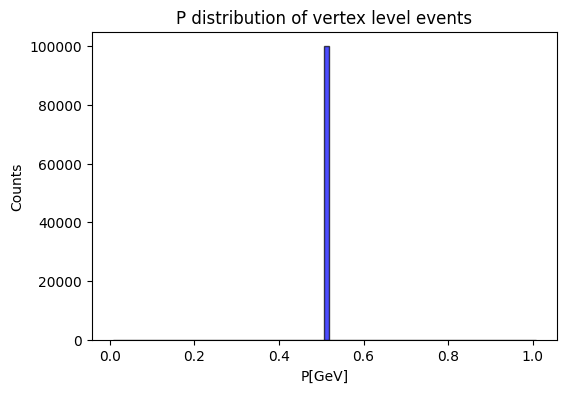

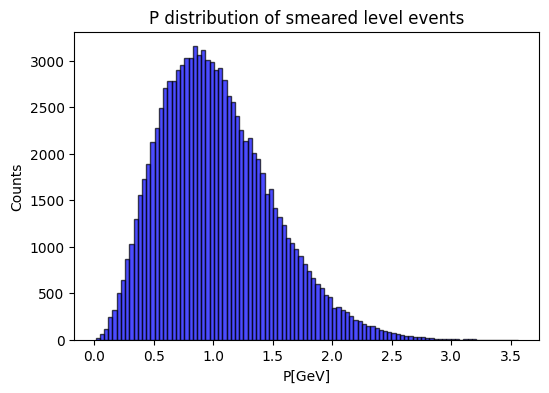

In [8]:
# Create 1D histograms for each component of the 4-momentum vector (identical_events)
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

# Plot a histogram for one component, say 'p0' (since all are identical)
ax.hist(P_PS, bins=100, alpha=0.7, color='blue', edgecolor='black')

# Add labels and title
ax.set_title("P distribution of vertex level events")
ax.set_xlabel("P[GeV]")
ax.set_ylabel("Counts")

# Show the plot
plt.show()

##############################

# Create 1D histograms for each component of the 4-momentum vector (identical_events)
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

# Plot a histogram for one component, say 'p0' (since all are identical)
ax.hist(P_smeared, bins=100, alpha=0.7, color='blue', edgecolor='black')

# Add labels and title
ax.set_title("P distribution of smeared level events")
ax.set_xlabel("P[GeV]")
ax.set_ylabel("Counts")

# Show the plot
plt.show()

### Training dataset loading + some checks and plots

(100000, 4) (100000, 4)


2024-11-15 00:08:46.141785: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


V_data mean: [ 0.10000002  0.05000001  0.07       -0.5       ]
V_data std dev: [1.4901161e-08 7.4505806e-09 0.0000000e+00 0.0000000e+00]
Smeared_data mean: [ 0.09995271  0.04942527  0.0712921  -0.5048375 ]
Smeared_data std dev: [0.09999724 0.5998347  0.39931166 0.70160353]
Numero di NaN in V_data per colonna: [0 0 0 0]
Numero di NaN in smeared_data per colonna: [0 0 0 0]


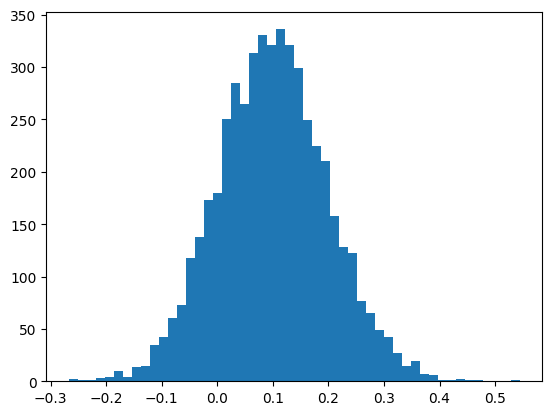

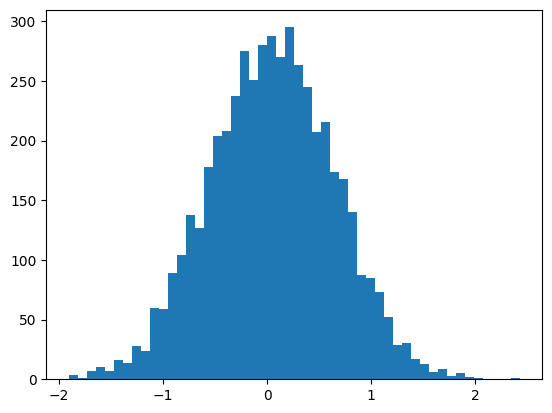

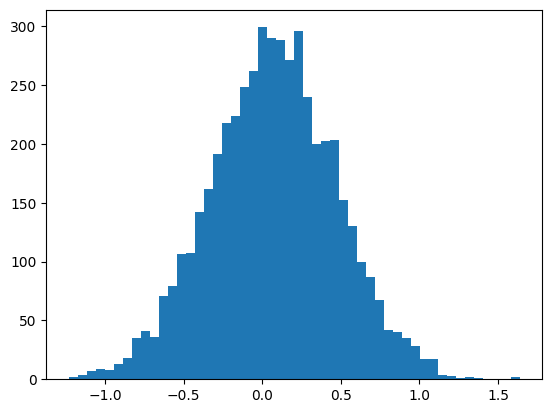

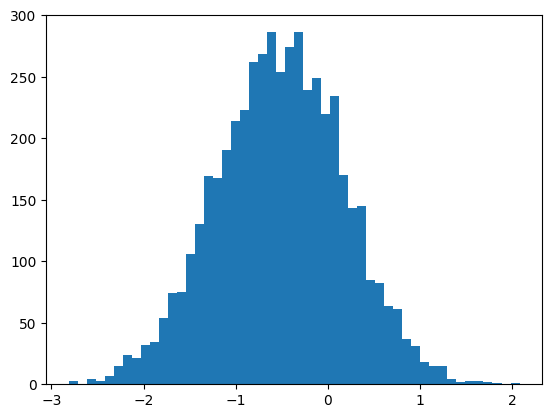

In [9]:
# Loading the dataset

V_data = tf.io.parse_tensor(tf.io.read_file(f'{PATH}/V_data'), out_type=tf.float32)
smeared_data = tf.io.parse_tensor(tf.io.read_file(f'{PATH}/smeared_data'), out_type=tf.float32)

# Check the structure of the loaded data:
print(V_data.shape, smeared_data.shape)

V_data_np = V_data.numpy()
smeared_data_np = smeared_data.numpy()

V_data_mean = tf.reduce_mean(V_data, axis=0)
V_data_std = tf.math.reduce_std(V_data, axis=0)

smeared_data_mean = tf.reduce_mean(smeared_data, axis=0)
smeared_data_std = tf.math.reduce_std(smeared_data, axis=0)

print("V_data mean:", V_data_mean.numpy())
print("V_data std dev:", V_data_std.numpy())

print("Smeared_data mean:", smeared_data_mean.numpy())
print("Smeared_data std dev:", smeared_data_std.numpy())

######## check for nan values 
nan_mask_V_data = tf.math.is_nan(V_data)
nan_per_column_V_data = tf.reduce_sum(tf.cast(nan_mask_V_data, tf.int32), axis=0)

nan_mask_smeared_data = tf.math.is_nan(smeared_data)
nan_per_column_smeared_data = tf.reduce_sum(tf.cast(nan_mask_smeared_data, tf.int32), axis=0)

print("Numero di NaN in V_data per colonna:", nan_per_column_V_data.numpy())
print("Numero di NaN in smeared_data per colonna:", nan_per_column_smeared_data.numpy())

###################################

plt.hist(smeared_data_np[:5000,0], bins=50)
plt.show()

plt.hist(smeared_data_np[:5000,1], bins=50)
plt.show()

plt.hist(smeared_data_np[:5000,2], bins=50)
plt.show()

plt.hist(smeared_data_np[:5000,3], bins=50)
plt.show()

In [10]:
training_events=smeared_data

print(training_events.shape)
print(training_events)

(100000, 4)
tf.Tensor(
[[ 0.14038092  1.5394523   0.06239881  0.16938931]
 [ 0.02582052  0.82223237  0.34098503  0.24046823]
 [ 0.02202651 -0.4015603   0.55726165  0.07430391]
 ...
 [ 0.10676268  0.8282838   0.16186114 -0.6669343 ]
 [ 0.11807545  0.5925897  -0.20848817 -1.3469244 ]
 [ 0.1320845  -1.1227736  -0.21232906  0.28751928]], shape=(100000, 4), dtype=float32)


### GAN model implementation

In [11]:
from tensorflow.keras.optimizers.legacy import Adam

t0 = time.time()
class LSGAN():
    def __init__(self):
        self.latent_dim = 100
        optimizer = Adam(learning_rate=0.0001, beta_1=0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        generator_noise = Input(shape=(self.latent_dim,))
        Det_events = self.generator([generator_noise])

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The valid takes generated detector_events as input and determines validity
        valid = self.discriminator(Det_events)
       
        # The combined model  (stacked generator and discriminator)--->Trains generator to fool discriminator
        self.combined = Model([generator_noise], valid )
        
        # (!!!) Optimize w.r.t. MSE loss instead of crossentropy
        # MMD_loss = self.MMD_loss()    
        self.combined.compile(loss='mse', optimizer=optimizer)    
        
    def build_generator(self):
        noise = Input(shape=(self.latent_dim,))
        
        x= Dense(64)(noise)
        x=LeakyReLU(alpha=0.2)(x)
        #x=BatchNormalization(momentum=0.8)(x)
        
        x= Dense(128)(x)
        x=LeakyReLU(alpha=0.2)(x)
        #x=BatchNormalization(momentum=0.8)(x)
        
        x= Dense(256)(x)
        x=LeakyReLU(alpha=0.2)(x)
        #x=BatchNormalization(momentum=0.8)(x)
        
        output = Dense(4)(x)
        # outputmerge = concatenate([v, output ])
        generator = Model(inputs=noise, outputs=output, name="generator")
        generator.summary()
        return(generator)
        
    def build_discriminator(self):
        D = Input(shape=(training_events.shape[1],))
        x = Dense(256)(D)
        x = LeakyReLU(alpha=0.2)(x)
        x = Dense(128)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Dense(64)(x)
        x = LeakyReLU(alpha=0.2)(x)
        output = Dense(1)(x)
        discriminator = Model(inputs=D, outputs=output, name="discriminator")
        discriminator.summary()
        return discriminator

    def train(self, epochs, batch_size=128, sample_interval=50): 
        # training loop for the full model
        
        X_train = training_events
        
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        dloss=[]
        gloss=[]
        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            #Select a random batch of real detector level events
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = tf.gather(X_train, idx)

            #Generates a batch of "fake" detector level events 
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_detect_evts = self.generator.predict([noise], verbose = 0)

            # ---------------------
            # Train the Discriminator
            # ---------------------
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_detect_evts, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            # ---------------------
            #  Train the Generator
            # ---------------------

            g_loss = self.combined.train_on_batch([noise], valid)

            dloss=np.append(dloss,d_loss[0])
            gloss=np.append(gloss,g_loss)
            if epoch % sample_interval == 0:
                print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
                self.sample_images(epoch, dloss, gloss)
                
                self.generator.save_weights('./Gauss_smearing/G_%d.h5'%(epoch+EP))
                self.discriminator.save_weights('./Gauss_smearing/D_%d.h5'%(epoch+EP))
                print('saved ...')

    def sample_images(self, epoch, dloss, gloss):

        dirname = f"./Gauss_smearing/{epoch+EP}/P"
        if not os.path.exists(dirname):
            os.makedirs(dirname)
        
        # plots the training varibales and compares them to the generated variables during the training
        
        t = time.time()
        time_elapsed = t - t0
        print("time elapsed: %.2f"%(time_elapsed))

        # Define SAMPLE_SIZE and noise
        SAMPLE_SIZE = 20000
        noise = np.random.normal(0, 1, (SAMPLE_SIZE, 100))

        # Generate samples using the generator
        results = self.generator.predict([noise], batch_size = 128)
        
        # Extract the 4-momenta components from generated samples
        generated_E = results[:, 0]
        generated_Px = results[:, 1]
        generated_Py = results[:, 2]
        generated_Pz = results[:, 3]
        
        G_P = tri_mom(results)

        # Sample real data for comparison
        idx = np.random.randint(0, training_events.shape[0], SAMPLE_SIZE)
        idx_tensor = tf.constant(idx, dtype=tf.int32)
        real_samples = tf.gather(training_events, idx_tensor)
        real_E = real_samples[:, 0]
        real_Px = real_samples[:, 1]
        real_Py = real_samples[:, 2]
        real_Pz = real_samples[:, 3]

        R_P = tri_mom(real_samples)

        print(results.shape, real_samples.shape)

        bin_centers_E, hist_real_E, hist_generated_E, err_real_E, err_generated_E, pulls_E = calculate_errors_and_pulls(real_E, generated_E)
        bin_centers_Px, hist_real_Px, hist_generated_Px, err_real_Px, err_generated_Px, pulls_Px = calculate_errors_and_pulls(real_Px, generated_Px)
        bin_centers_Py, hist_real_Py, hist_generated_Py, err_real_Py, err_generated_Py, pulls_Py = calculate_errors_and_pulls(real_Py, generated_Py)
        bin_centers_Pz, hist_real_Pz, hist_generated_Pz, err_real_Pz, err_generated_Pz, pulls_Pz = calculate_errors_and_pulls(real_Pz, generated_Pz)

                        # Plot histograms for P
        plt.figure(figsize=(10, 5))
        plt.hist(R_P, bins=50, alpha=0.5, label='Real P')
        plt.hist(G_P, bins=50, alpha=0.5, label='Generated P')
        plt.title('P Distribution')
        plt.legend()
        plt.savefig("./Gauss_smearing/%d/P"%(epoch+EP))
        plt.show()


        ## histograms for training variables
        fig, axs = plt.subplots(2, 2, figsize=(12, 10))
        # Plot histogram for E
        axs[0, 0].hist(real_E, bins=50, alpha=0.5, label='Real E')
        axs[0, 0].hist(generated_E, bins=50, alpha=0.5, label='Generated E')
        axs[0, 0].set_title('E Distribution')
        axs[0, 0].legend()

        # Plot histogram for Px
        axs[0, 1].hist(real_Px, bins=50, alpha=0.5, label='Real Px')
        axs[0, 1].hist(generated_Px, bins=50, alpha=0.5, label='Generated Px')
        axs[0, 1].set_title('Px Distribution')
        axs[0, 1].legend()

        # Plot histogram for Py
        axs[1, 0].hist(real_Py, bins=50, alpha=0.5, label='Real Py')
        axs[1, 0].hist(generated_Py, bins=50, alpha=0.5, label='Generated Py')
        axs[1, 0].set_title('Py Distribution')
        axs[1, 0].legend()

        # Plot histogram for Pz
        axs[1, 1].hist(real_Pz, bins=50, alpha=0.5, label='Real Pz')
        axs[1, 1].hist(generated_Pz, bins=50, alpha=0.5, label='Generated Pz')
        axs[1, 1].set_title('Pz Distribution')
        axs[1, 1].legend()

        # Adjust layout for spacing and display the plots
        plt.tight_layout()
        plt.savefig("./Gauss_smearing/%d/Training_variables"%(epoch+EP))
        plt.show()        
        
        nrows,ncols=1,1
        fig = pyy.figure(figsize=(ncols*7,nrows*5))

        ax=pyy.subplot(nrows,ncols,1)
        ax.plot(range(1,len(gloss)+1),gloss,label=r'$\rm generator$')
        ax.plot(range(1,len(dloss)+1),dloss,label=r'$\rm discriminator$')
        ax.semilogy()
        ax.semilogx()
        ax.legend(fontsize=20)
        ax.set_ylabel(r'$\rm Loss$',size=20)
        ax.set_xlabel(r'$\rm epochs$',size=20)
        ax.tick_params(axis='both', which='both', labelsize=15,direction='in')
        plt.savefig("./Gauss_smearing/loss_function_%d"%(epoch+EP))
        plt.show()

In [12]:
gan = LSGAN()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense (Dense)               (None, 256)               1280      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 64)              

0 [D loss: 0.445781, acc.: 50.00%] [G loss: 0.903901]
time elapsed: 2.49
157/157 [==============================] - 0s 1ms/step
(20000, 4) (20000, 4)


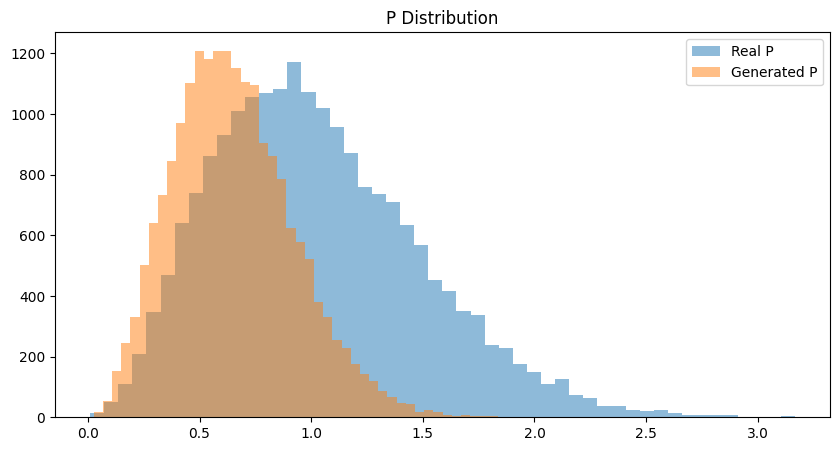

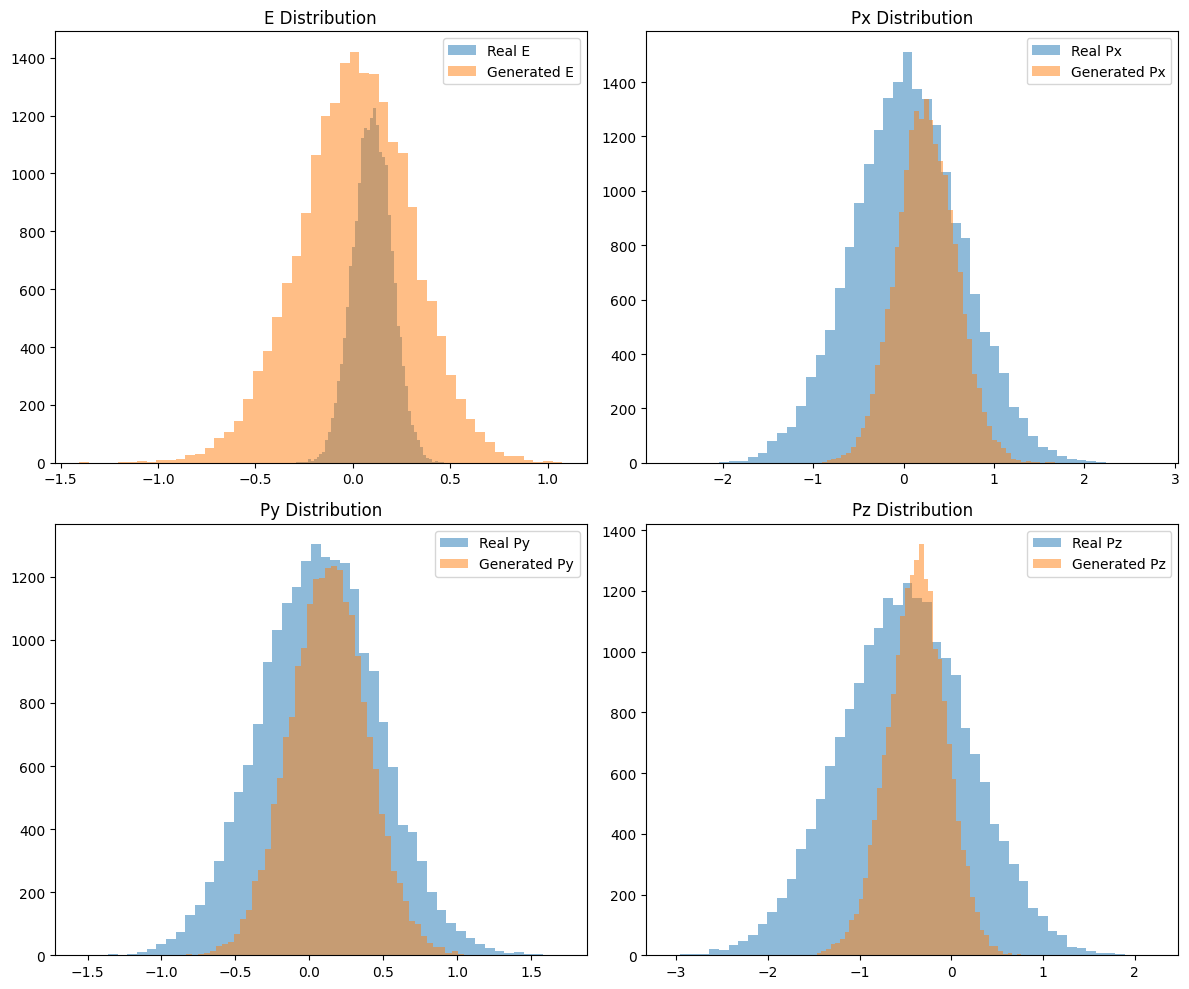

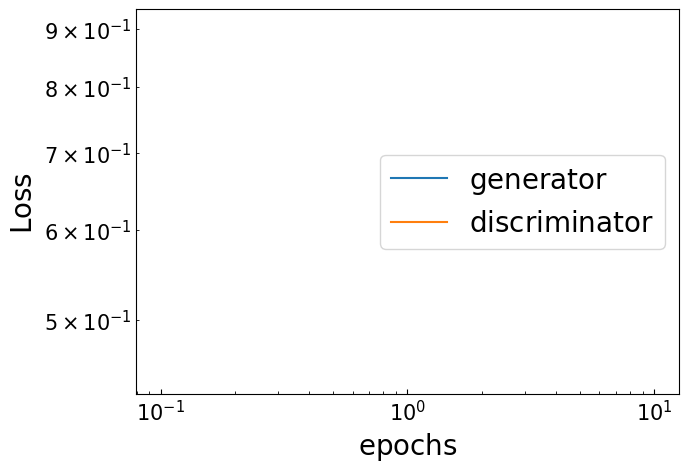

saved ...
100 [D loss: 0.272804, acc.: 55.01%] [G loss: 0.595551]
time elapsed: 97.93
157/157 [==============================] - 0s 1ms/step
(20000, 4) (20000, 4)


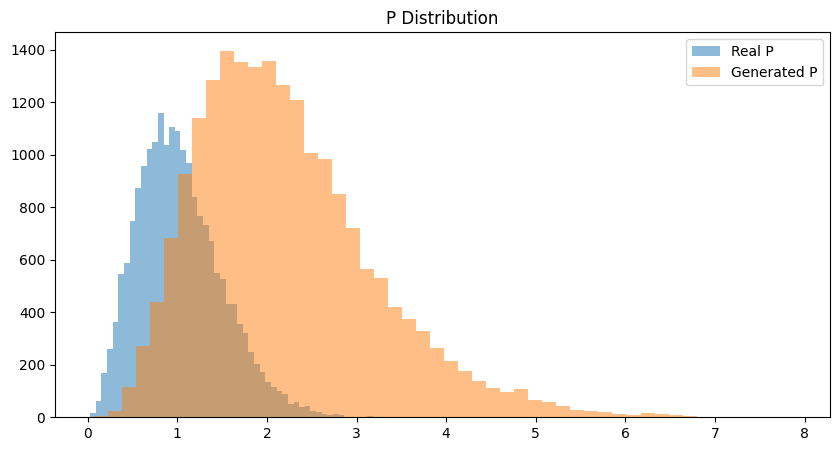

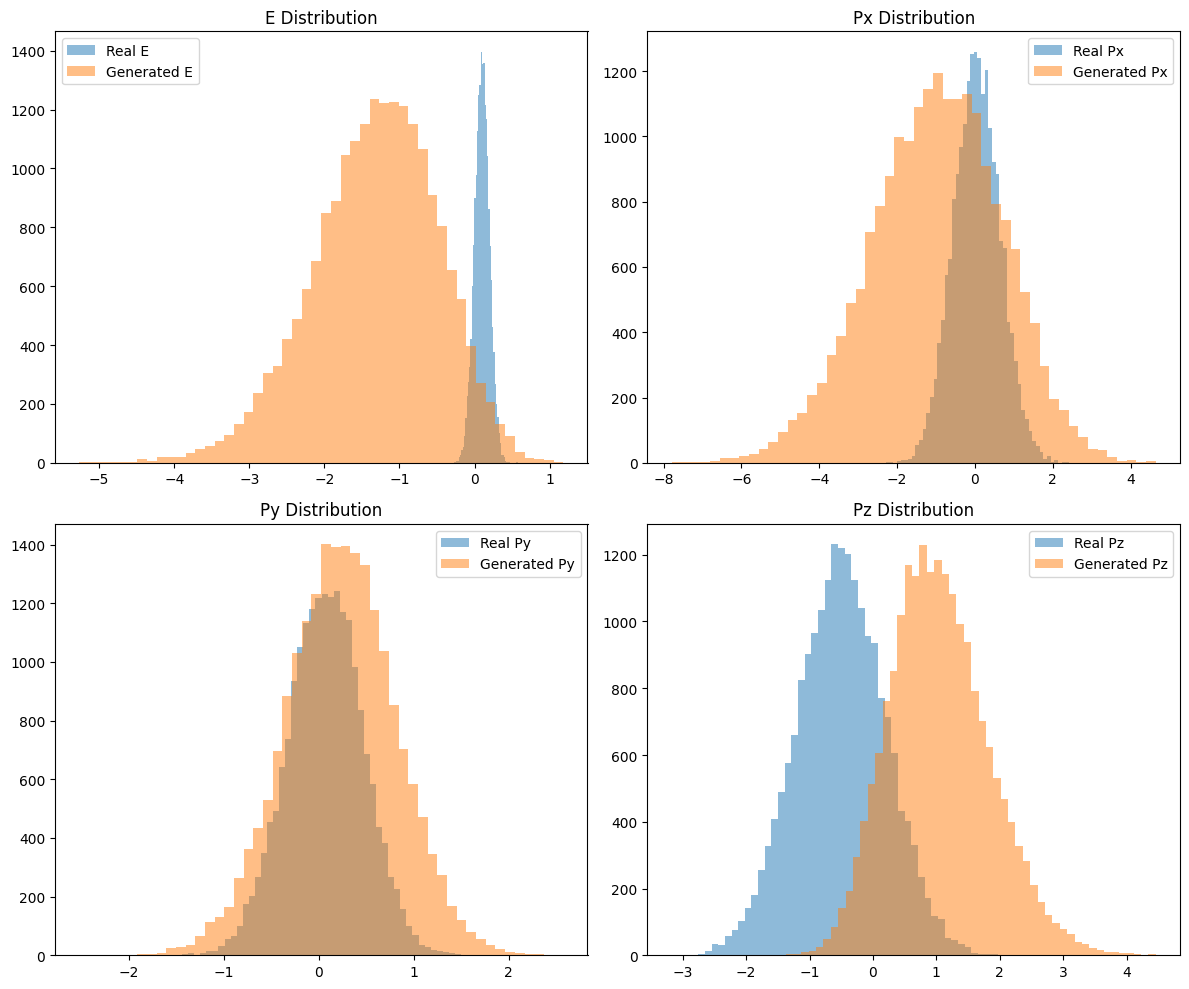

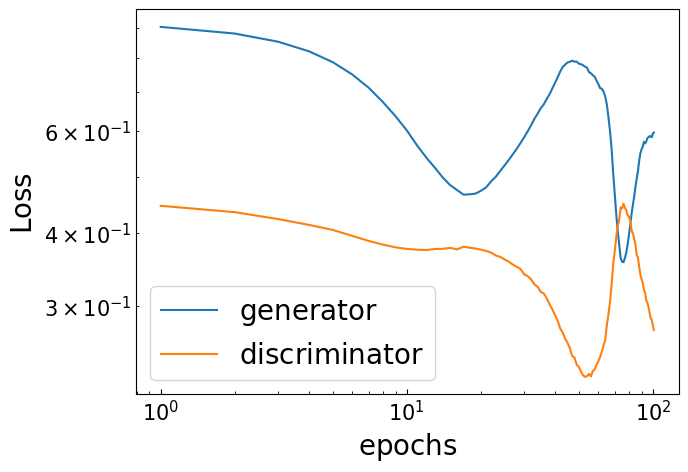

saved ...
200 [D loss: 0.238187, acc.: 52.44%] [G loss: 0.370047]
time elapsed: 194.28
157/157 [==============================] - 0s 1ms/step
(20000, 4) (20000, 4)


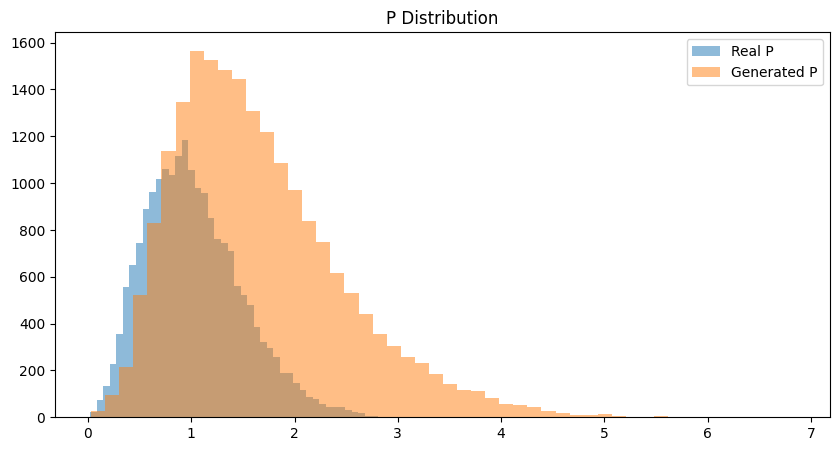

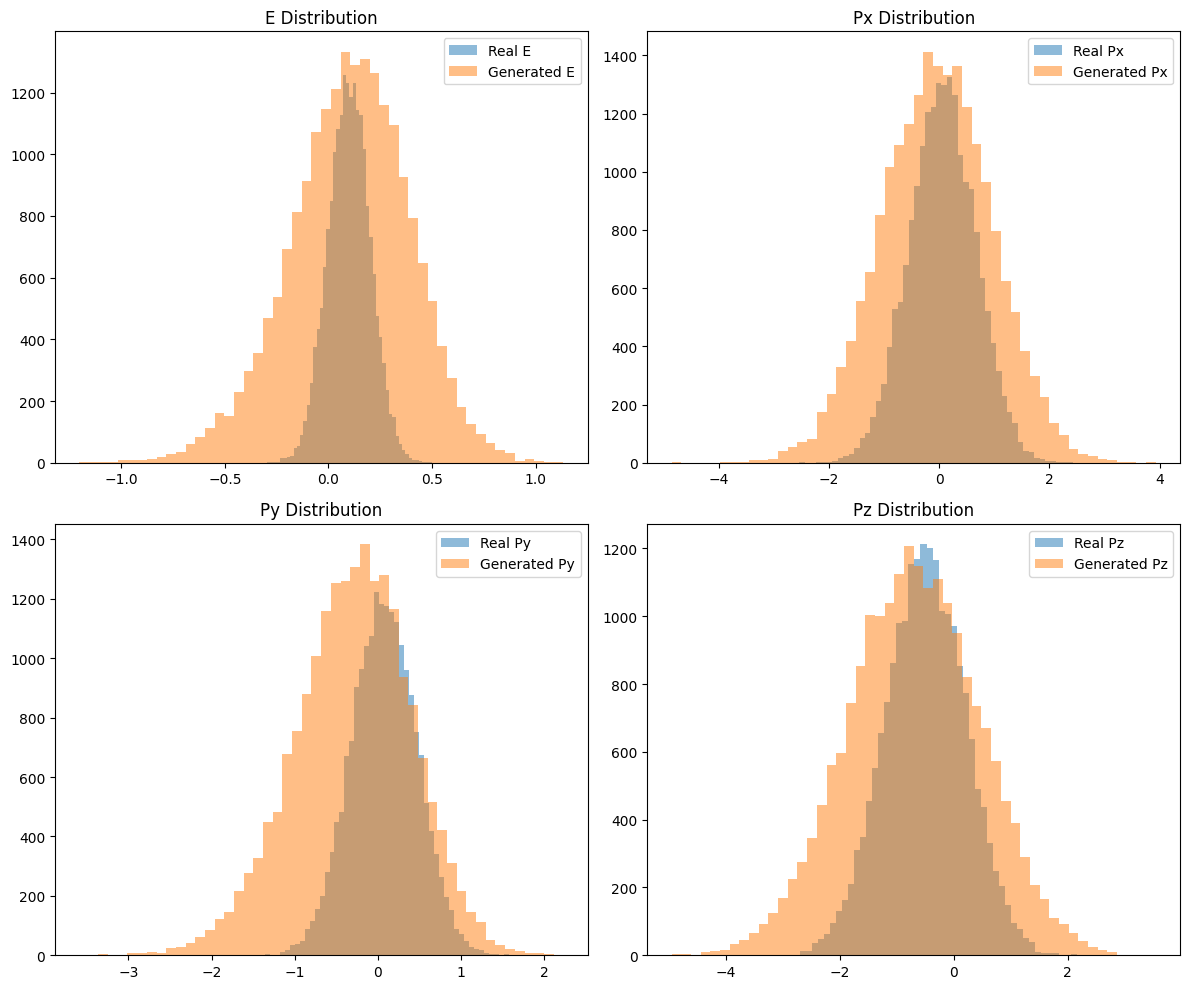

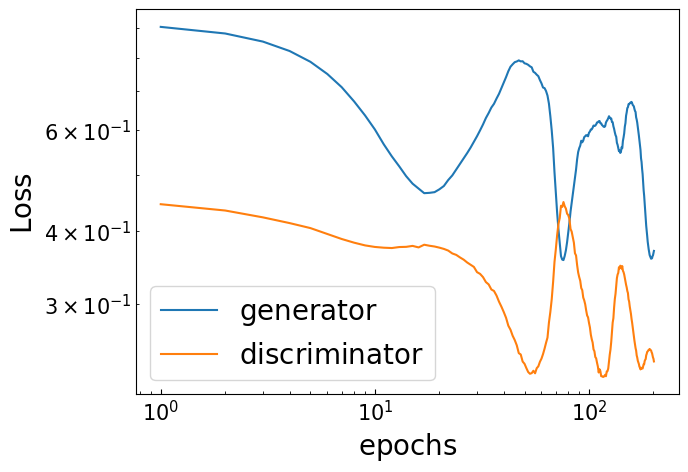

saved ...
300 [D loss: 0.260434, acc.: 42.76%] [G loss: 0.245379]
time elapsed: 289.88
157/157 [==============================] - 0s 1ms/step
(20000, 4) (20000, 4)


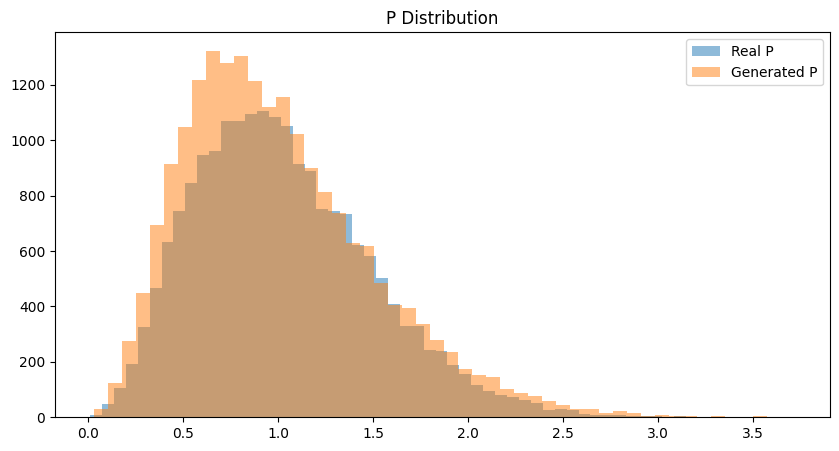

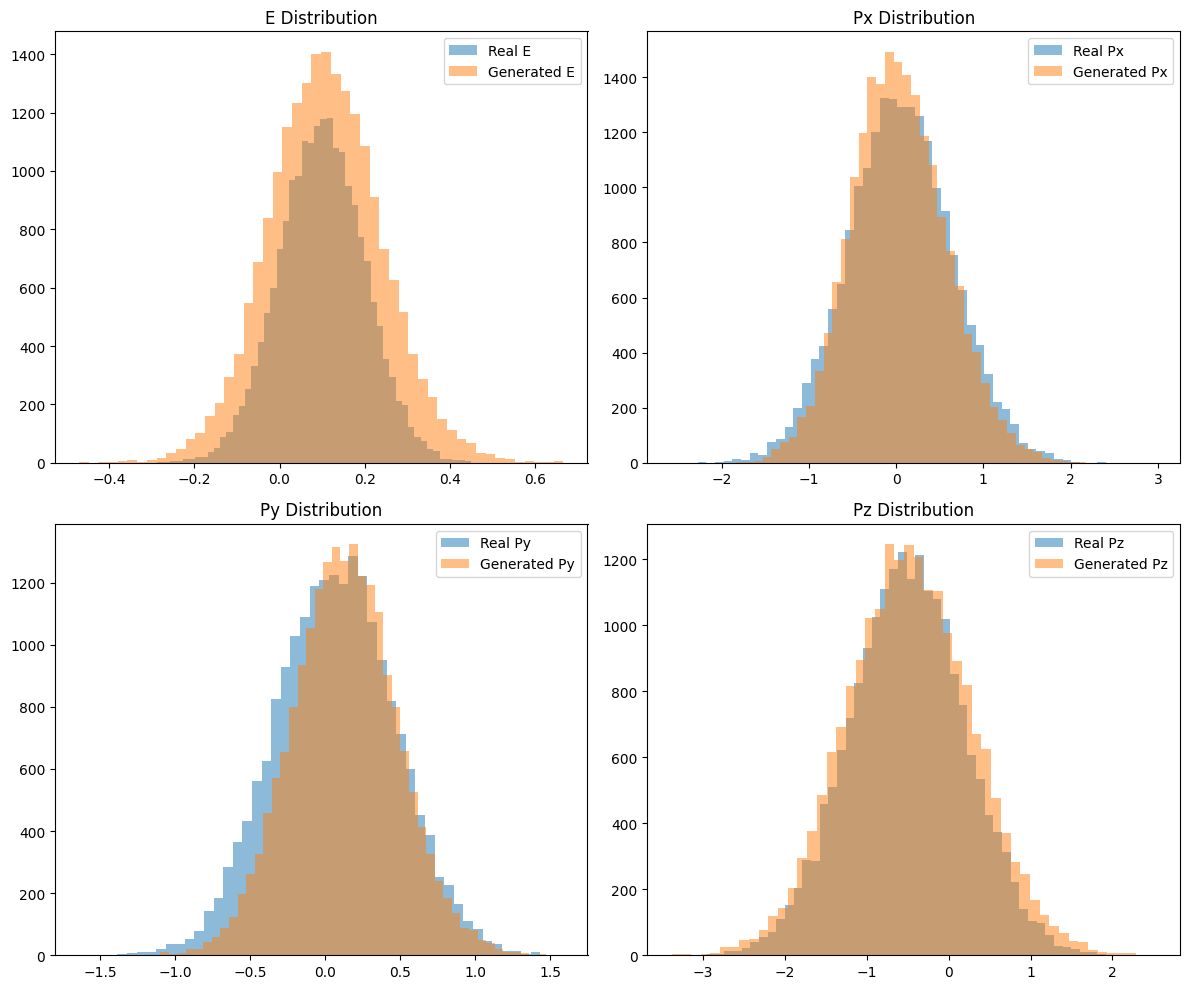

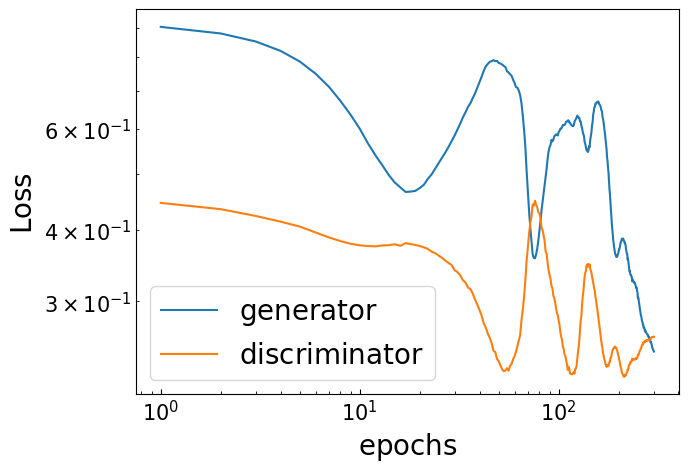

saved ...
400 [D loss: 0.249083, acc.: 48.18%] [G loss: 0.233182]
time elapsed: 385.80
157/157 [==============================] - 0s 1ms/step
(20000, 4) (20000, 4)


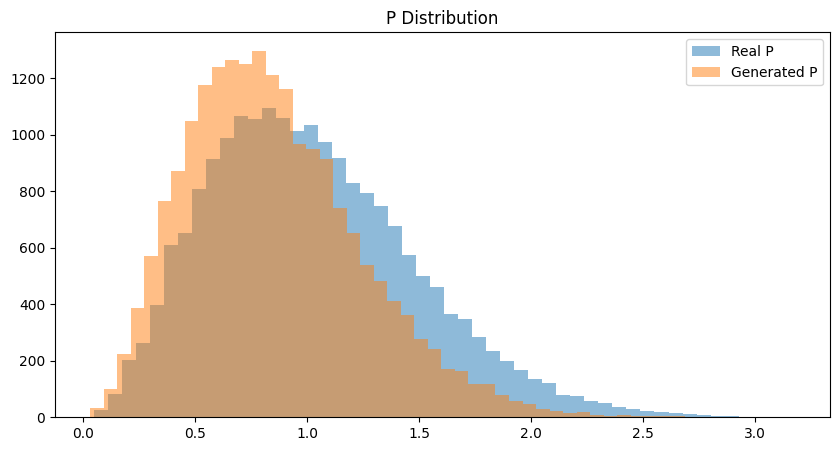

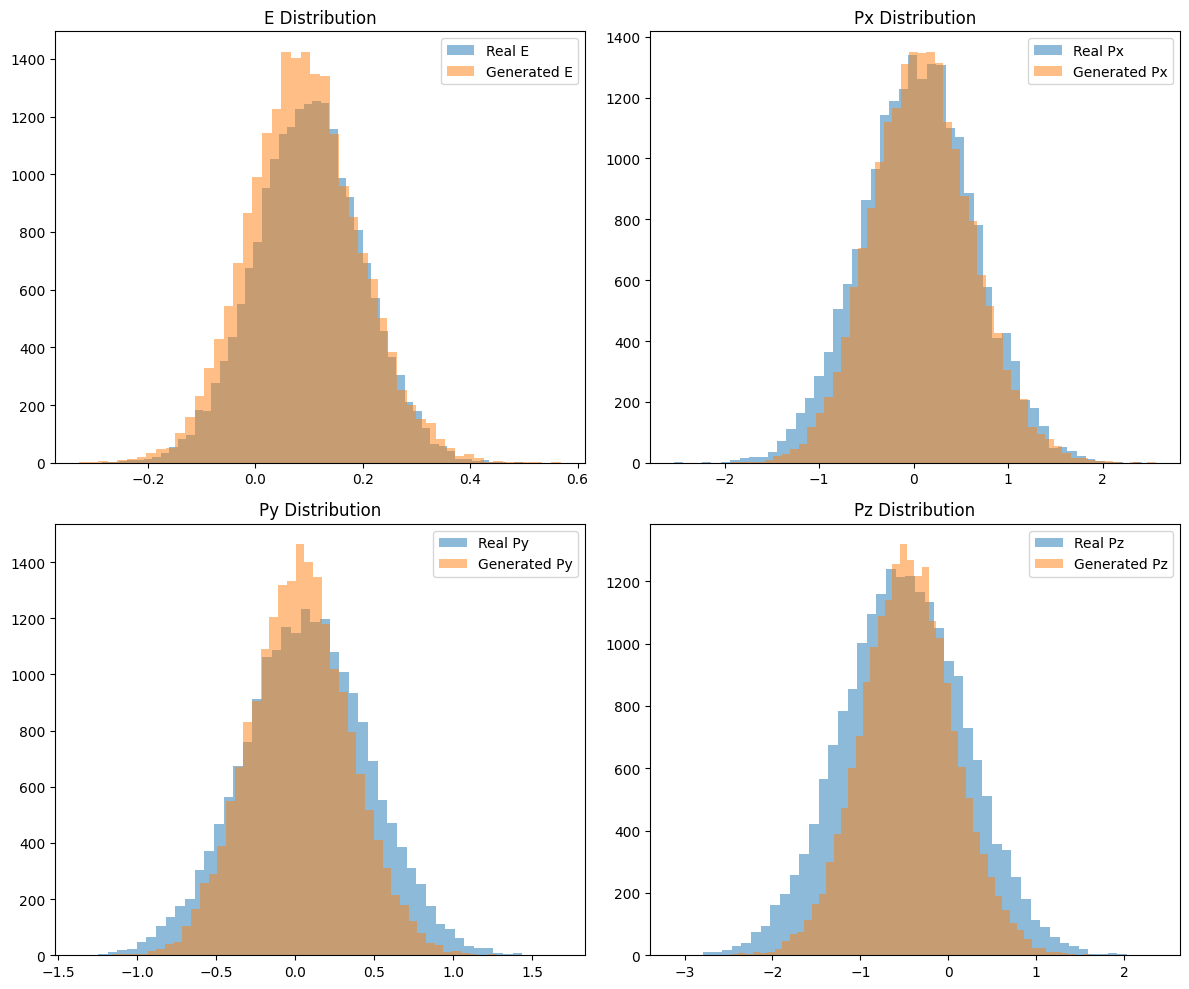

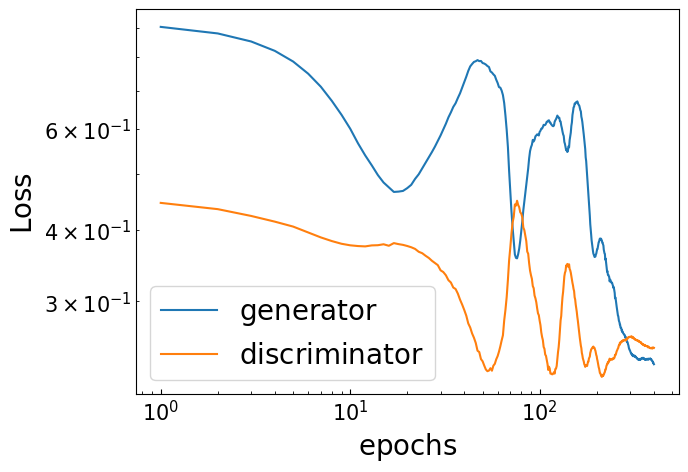

saved ...
500 [D loss: 0.257848, acc.: 47.33%] [G loss: 0.240177]
time elapsed: 483.57
157/157 [==============================] - 0s 1ms/step
(20000, 4) (20000, 4)


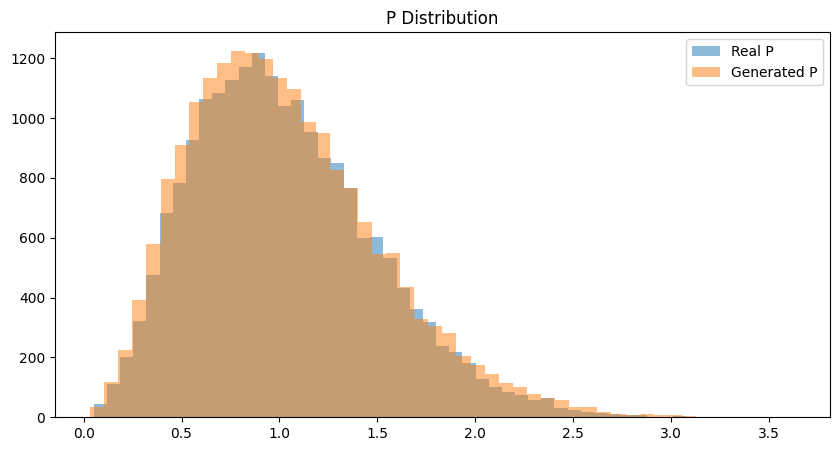

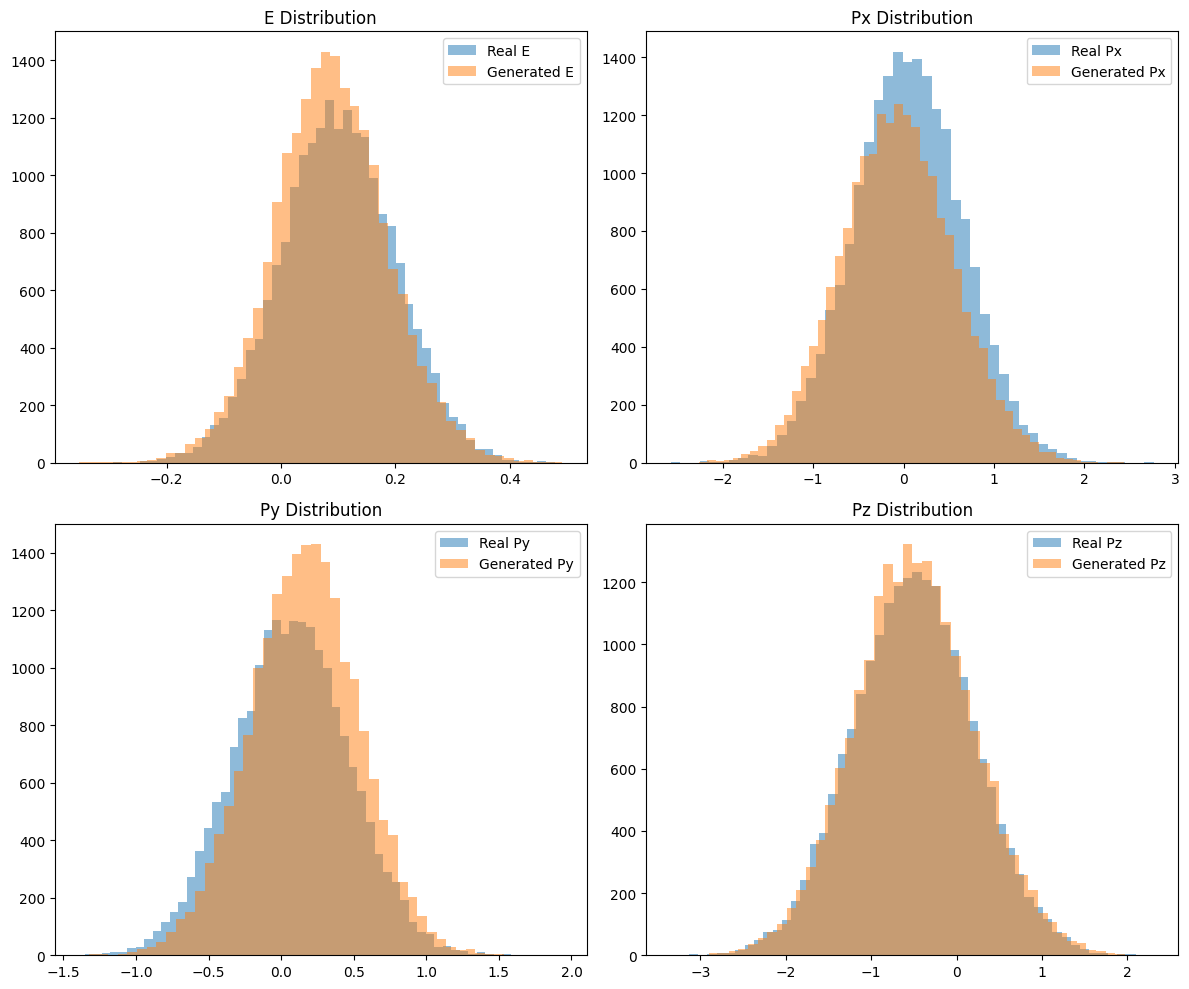

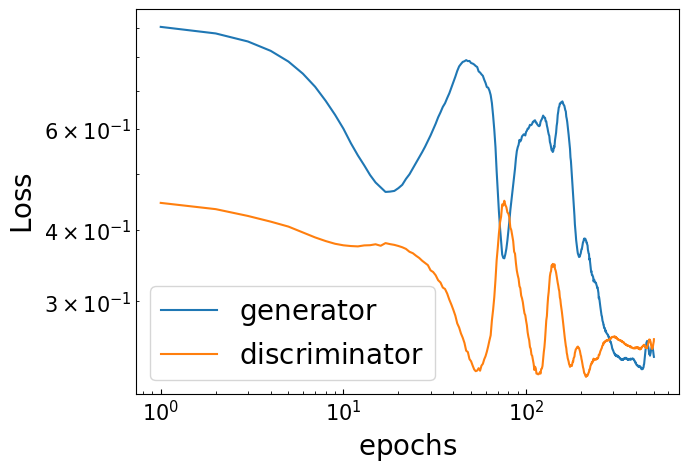

saved ...


In [13]:
t0 = time.time()
EP = 0

#gan.generator.load_weights('/home/private/Gauss_smearing/G_%d.h5'%(EP))
#gan.discriminator.load_weights('/home/private/Gauss_smearing/D_%d.h5'%(EP))

gan.train(epochs=501, batch_size=10000, sample_interval=100)

1/1 [==============================] - 0s 25ms/step
(10000, 4) (10000, 4)


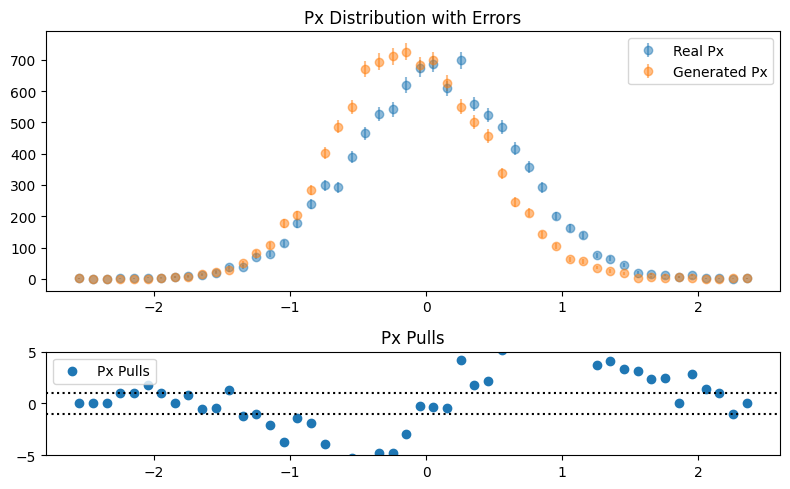

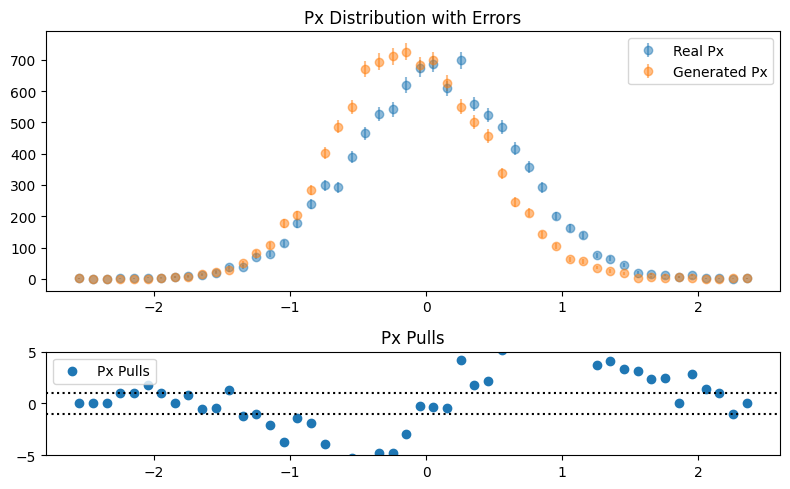

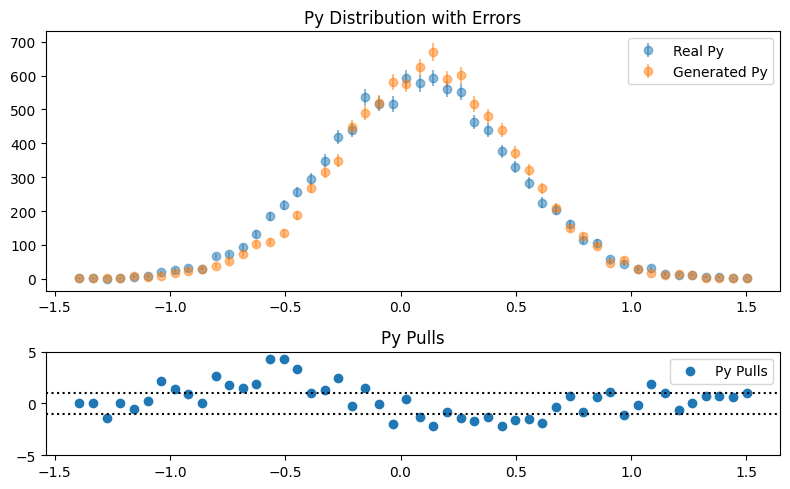

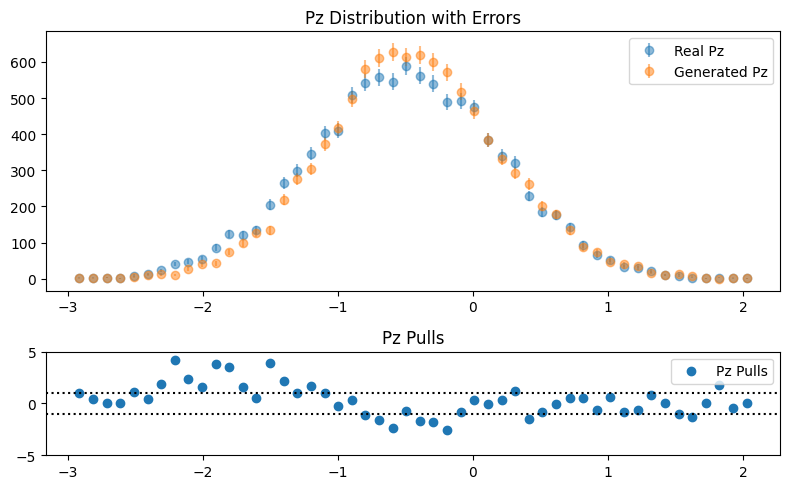

In [14]:
EP = 500

gan.generator.load_weights('./Gauss_smearing/G_%d.h5'%(EP))
gan.discriminator.load_weights('./Gauss_smearing/D_%d.h5'%(EP))

SAMPLE_SIZE = 10000
noise = np.random.normal(0, 1, (SAMPLE_SIZE, 100))

results = gan.generator.predict([noise], batch_size = 10000) ###BATCHSIZE = 128


        #Extract the different components from generated samples
generated_E = results[:, 0]
generated_Px = results[:, 1]
generated_Py = results[:, 2]
generated_Pz = results[:, 3]

G_P = tri_mom(results)

        # Sample real data for comparison
idx = np.random.randint(0, training_events.shape[0], SAMPLE_SIZE)
idx_tensor = tf.constant(idx, dtype=tf.int32)
real_samples = tf.gather(training_events, idx_tensor)

real_E = real_samples[:, 0]
real_Px = real_samples[:, 1]
real_Py = real_samples[:, 2]
real_Pz = real_samples[:, 3]

R_P = tri_mom(real_samples)

print(results.shape, real_samples.shape)


bin_centers_E, hist_real_E, hist_generated_E, err_real_E, err_generated_E, pulls_E = calculate_errors_and_pulls(real_E, generated_E)
bin_centers_Px, hist_real_Px, hist_generated_Px, err_real_Px, err_generated_Px, pulls_Px = calculate_errors_and_pulls(real_Px, generated_Px)
bin_centers_Py, hist_real_Py, hist_generated_Py, err_real_Py, err_generated_Py, pulls_Py = calculate_errors_and_pulls(real_Py, generated_Py)
bin_centers_Pz, hist_real_Pz, hist_generated_Pz, err_real_Pz, err_generated_Pz, pulls_Pz = calculate_errors_and_pulls(real_Pz, generated_Pz)


        ############ Plot errors for E
fig, axs = plt.subplots(2, 1, figsize=(8, 5), gridspec_kw={'height_ratios': [5, 2]})

# Top plot for Px distribution with errors
axs[0].errorbar(bin_centers_Px, hist_real_Px, yerr=err_real_Px, fmt='o', label='Real Px', alpha=0.5)
axs[0].errorbar(bin_centers_Px, hist_generated_Px, yerr=err_generated_Px, fmt='o', label='Generated Px', alpha=0.5)
axs[0].set_title('Px Distribution with Errors')
axs[0].legend()

        # Bottom plot for Px pulls
axs[1].scatter(bin_centers_Px, pulls_Px, label='Px Pulls')
axs[1].axhline(1, ls=':', color='k')
axs[1].axhline(-1, ls=':', color='k')
axs[1].set_ylim(-5, 5)
axs[1].set_title('Px Pulls')
axs[1].legend()

plt.tight_layout()
plt.show()


        ########### Plot errors for Px
fig, axs = plt.subplots(2, 1, figsize=(8, 5), gridspec_kw={'height_ratios': [5, 2]})

        # Top plot for Px
axs[0].errorbar(bin_centers_Px, hist_real_Px, yerr=err_real_Px, fmt='o', label='Real Px', alpha=0.5)
axs[0].errorbar(bin_centers_Px, hist_generated_Px, yerr=err_generated_Px, fmt='o', label='Generated Px', alpha=0.5)
axs[0].set_title('Px Distribution with Errors')
axs[0].legend()

        # Plot pulls for Px
axs[1].scatter(bin_centers_Px, pulls_Px, label='Px Pulls')
axs[1].axhline(1, ls=':', color='k')
axs[1].axhline(-1, ls=':', color='k')
axs[1].set_ylim(-5, 5)
axs[1].set_title('Px Pulls')
axs[1].legend()

plt.tight_layout()
plt.show()


        ########### Plot errors for Py
fig, axs = plt.subplots(2, 1, figsize=(8, 5), gridspec_kw={'height_ratios': [5, 2]})

        # Top plot for Py
axs[0].errorbar(bin_centers_Py, hist_real_Py, yerr=err_real_Py, fmt='o', label='Real Py', alpha=0.5)
axs[0].errorbar(bin_centers_Py, hist_generated_Py, yerr=err_generated_Py, fmt='o', label='Generated Py', alpha=0.5)
axs[0].set_title('Py Distribution with Errors')
axs[0].legend()

        # Plot pulls for Py
axs[1].scatter(bin_centers_Py, pulls_Py, label='Py Pulls')
axs[1].axhline(1, ls=':', color='k')
axs[1].axhline(-1, ls=':', color='k')
axs[1].set_ylim(-5, 5)
axs[1].set_title('Py Pulls')
axs[1].legend()

plt.tight_layout()
plt.show()


        ########### Plot errors for Pz
fig, axs = plt.subplots(2, 1, figsize=(8, 5), gridspec_kw={'height_ratios': [5, 2]})

        # Top plot for Pz
axs[0].errorbar(bin_centers_Pz, hist_real_Pz, yerr=err_real_Pz, fmt='o', label='Real Pz', alpha=0.5)
axs[0].errorbar(bin_centers_Pz, hist_generated_Pz, yerr=err_generated_Pz, fmt='o', label='Generated Pz', alpha=0.5)
axs[0].set_title('Pz Distribution with Errors')
axs[0].legend()

        # Plot pulls for Pz
axs[1].scatter(bin_centers_Pz, pulls_Pz, label='Pz Pulls')
axs[1].axhline(1, ls=':', color='k')
axs[1].axhline(-1, ls=':', color='k')
axs[1].set_ylim(-5, 5)
axs[1].set_title('Pz Pulls')
axs[1].legend()

plt.tight_layout()
plt.show()

### Proposed exercise

In [15]:
## ~ 6min ogni 500 epoche. Dopo le 1500 epoche, il training smette di migliorare

In [16]:
# --> Change the dimensionality of the architecture:
        # - Make the models less complex (to understand where is the lower limit in which the model
        #    loses expressivity

        # - Make the model more complex (deeper and wider) to see if there how much we improve the results 
        #    compared to a simpler one

# --> Understand the dinamic training of the model: 
        # - Make the model unbalanced (Discriminator >> Generator) or viceversa and look at the loss function
        #    during the training to see what happens to the convergence of the model

        # - Play with the batch size of the training to see what is the minimum number of events that gives a full
        #    generalisable model